In [1]:
"""
Max Bongers
30-6-2023
MRI and Monte Carlo Model for master thesis "Optimizing b-value Composition For Maximizing ADC Contrast between Cancerous and Healthy Breast Tissue using a Diffusion Weighted MRI Simulator"
"""

'\nMax Bongers\n30-6-2023\nMRI and Monte Carlo Model for master thesis "Optimizing b-value Composition For Maximizing ADC Contrast between Cancerous and Healthy Breast Tissue using a Diffusion Weighted MRI Simulator"\n'

In [2]:
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
import random
from shapely.geometry import Polygon, Point
import json
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera
import planar
from scipy.spatial.transform import Rotation
import copy
import pandas as pd
import cv2
import matplotlib.animation as animation
from math import sin, cos
import multiprocessing
from multiprocessing import Queue
from numba import jit, cuda
import numba as numba
import time
import os
from scipy.stats import norm, kurtosis

In [3]:
# checks whether if and which cell the spin is located in
# returns False if outside a cell, otherwise returns the cell
def check_cell(x,y, compartment_cells, centroid_compartments):
    # calculate distance to each compartment (based on center of compartment)
    distances = np.linalg.norm(np.array([x,y]) - centroid_compartments, axis=1)
    # check 4 nearby compartments
    sort_dist = np.argsort(distances)[0:4]
    close_cells_comp = compartment_cells[sort_dist]
    # flatten compartments into 1
    close_cells = [x for cell in close_cells_comp for x in cell]
    for cell in close_cells:
        if cell.contains_point((x,y)):
            return cell
    return False


def check_incell_xy(x,y,x1,y1, cell):
    orX = x
    orY = y
    wallcheck = None
    # if the step puts you inside the cell again, you didn't collide with any walls so return the step as normal
    if cell.contains_point((x1,y1)):
        return (x1-x, y1-y)
    
    count = 0
    # loop through cell walls
    while not cell.contains_point((x1,y1)):
        original_step = np.array([[x,y],[x1,y1]])
        cellist = cell
        for wall in range(len(cellist)-1):
            colliding_wall = np.array([cellist[wall],cellist[wall+1]])
            inters = nb_get_line_intersect(original_step, colliding_wall)
            # convoluted way of checking collision
            # if inters is not empty, there is a collision
            if inters[0] != 0. or inters[1] != 0.:
                # skip collision check over the wall you just collided with, as you will always collide with this
                # wall if you're inside it
                if wallcheck != wall:
                    # uncomment to plot cell spin is currently in
                    """
                    print("Plot")
                    plt.plot([x,x1],[y,y1], label="Original step", color="lime")
                    """
                    # rotate step beyond the collision around the point of intersection, this way the reflection
                    # will be exactly the right size
                    angle = ang(original_step,colliding_wall) * 2
                    rotated = rotateP([original_step[1][0],original_step[1][1]],math.radians(angle),inters)
                    x1 = rotated[0]
                    y1 = rotated[1]
                    x = inters[0]
                    y = inters[1]
                    # update wall you last collided with
                    wallcheck = wall
                    """"
                    xs, ys = zip(*cell) 
                    plt.plot(xs,ys, color="black")
                    plt.plot([colliding_wall[0][0],colliding_wall[1][0]],[colliding_wall[0][1],colliding_wall[1][1]], label="Colliding wall", color="blue")
                    plt.plot([a[0],rotated[0]],[a[1],rotated[1]], label="Reflection", color="red")
                    plt.legend()
                    plt.show()
                    """
                    break
    
    return (rotated[0]-orX, rotated[1]-orY)


# reflects the step on the inside of a cell. Only checks the walls of the cell the spin is currently in
# continually reflects until no more collisions occur
def check_outcell_xy(x,y,x1,y1, compartment_walls, compartment_wall_mids, centroid_compartments, latest_walls, j):
    orX = x
    orY = y
    rotated = [x1,y1]
    wallcheck = np.array([[2, 2], [2, 2]])
    
    # Check once every 5 timesteps
    if j % 5 == 0:
        distances = np.linalg.norm(np.array([x,y]) - centroid_compartments, axis=1)
        sort_dist = np.argsort(distances)[0:4]
        compartment_wall_mids_sort = compartment_wall_mids[sort_dist]
        compartment_walls_sort = compartment_walls[sort_dist]
        # flatten close compartments
        local_mids = np.array([X for bb in compartment_wall_mids_sort for X in bb])
        local_walls = np.array([X for bb in compartment_walls_sort for X in bb])

        # If you don't have any walls nearby, you can't collide with any, so return step as normal
        if not local_mids.any():
            nearby_walls = np.array([])
            return (x1-orX, y1-orY, latest_walls)
        
        # second close wall check (on top of checking compartments), currently at 0.01mm
        max_distance = 0.01
        p = np.array([x,y])
        # calculate distance to each compartment (based on center of compartment) 
        distances = np.linalg.norm(p - local_mids, axis=1)
        colliding_wall_segment_indices = np.where(distances < max_distance)[0] 
        # save nearby walls for future reference
        nearby_walls = local_walls[colliding_wall_segment_indices]
    else:
        nearby_walls = latest_walls
    nearby_walls = np.asarray(nearby_walls) 

    # if there are any nearby walls
    while(nearby_walls.size > 0):
        short = 99999999
        intersect = False
        original_step = np.array([[x,y],[x1,y1]])
        # loop through nearby walls
        for wall in nearby_walls:
            if not np.array_equal(wall, wallcheck):
                # loop through all local walls to find the closest one you collide with, this way collision 
                # also works if your step size is large and can hit two walls at once
                colliding_wall = np.array([wall[0],wall[1]])
                inters = nb_get_line_intersect(original_step, colliding_wall)
                if inters[0] != 0. or inters[1] != 0.:
                    intersect = True
                    new = math.dist(inters, [x,y])
                    if new < short:
                        short = new
                        shortwall = wall
                        
        # check collision angle with closest wall
        if intersect == True:
            # reflects the step
            colliding_wall = np.array([shortwall[0],shortwall[1]])
            inters = nb_get_line_intersect(original_step, colliding_wall)
            angle = 360 - (ang(original_step,colliding_wall) * 2)
            rotated = rotateP([original_step[1][0],original_step[1][1]],math.radians(angle),inters)
            """
            print("Plot")
            plt.plot([x,x1],[y,y1])
            """
            x1 = rotated[0]
            y1 = rotated[1]
            x = inters[0]
            y = inters[1]
            wallcheck = shortwall
            """
            for AA in nearby_walls:
                plt.plot([AA[0][0],AA[1][0]],[AA[0][1],AA[1][1]], color="black")
            plotty = colliding_wall
            plt.plot([plotty[0][0],plotty[1][0]],[plotty[0][1],plotty[1][1]])
            plt.plot([inters[0],rotated[0]],[inters[1],rotated[1]])
            plt.show()
            """
        else:
            latest_walls = nearby_walls
            return (rotated[0] - orX, rotated[1] - orY, latest_walls)
    latest_walls = nearby_walls
    return (x1-orX, y1-orY, latest_walls)

        
def plotz(x,y,particle=0):
    fig, ax = plt.subplots()
    line, = ax.plot(x[particle], y[particle], color='blue')


    def update(num, x, y, line):
        line.set_data(x[:num+1], y[:num+1])
        #line.axes.axis([0, 100, 0, 100])
        return line,


    for i in polys:
        xs, ys = zip(*i) 
        plt.plot(xs,ys, color="black")

    ani = animation.FuncAnimation(fig, update, len(x[0]), fargs=[x[particle], y[particle], line],
                                  interval=100, blit=True)


    ani.save('test.gif')
    plt.show()
    
# runs as many processes as there are cores available
def multiT(arg, count):
    start = time.time()
    processes = []
    magnet = []
    positions = []
    qT = Queue()
    qP = 2#Queue() -- old queue used for saving positions, took to much memory so it was scrapped
    arg.append(qT)
    arg.append(qP)
    start = time.time()
    
    for i in range(count):
        p = multiprocessing.Process(target=simulate, args=(arg))
        processes.append(p)
        p.start()

    # get processes from queue (multiprocessing)
    for p in processes:
        ret = qT.get() # will block
        magnet.append(ret)
        #ret1 = qP.get() # will block
        #positions.append(ret1)
        
    for p in processes:
        p.join()
    
    end = time.time()
    print("Duration    ", end-start)    
    return get_trans(magnet), _#positionXYZ(positions)

# combines xyz positions from different processes (currently not used)
def positionXYZ(positions):
    x = []
    y = []
    z = []
    for i in range(len(positions)):
        for j in positions[i][0]:
            x.append(j)
        for j in positions[i][1]:
            y.append(j)
        for j in positions[i][2]:
            z.append(j)
    return (x,y,z)

# combines magnetisation from different processes
def get_trans(magnet):
    trans = []
    long = []
    for j in range(len(magnet[0])):
        transX = 0
        transY = 0
        longZ = 0
        for i in magnet:
            transX += i[j][0]
            transY += i[j][1]
            longZ += i[j][2]
        trans.append(np.linalg.norm([transX,transY]))
        long.append(np.linalg.norm([longZ]))
    return trans, long


# checks for convexity of polygons, used for cell creation.
# makes it more efficient to check if you're inside the cell
def is_convex_polygon(polygon):
    try:
        if len(polygon) < 3:
            return False
        old_x, old_y = polygon[-2]
        new_x, new_y = polygon[-1]
        new_direction = math.atan2(new_y - old_y, new_x - old_x)
        angle_sum = 0.0
        for ndx, newpoint in enumerate(polygon):
            old_x, old_y, old_direction = new_x, new_y, new_direction
            new_x, new_y = newpoint
            new_direction = math.atan2(new_y - old_y, new_x - old_x)
            if old_x == new_x and old_y == new_y:
                return False
            angle = new_direction - old_direction

            if angle <= -math.pi:
                angle += 2 * math.pi 
            elif angle > math.pi:
                angle -= 2 * math.pi
            if ndx == 0: 
                if angle == 0.0:
                    return False
                orientation = 1.0 if angle > 0.0 else -1.0
            else:
                if orientation * angle <= 0.0:
                    return False
            angle_sum += angle
        return abs(round(angle_sum / 2 * math.pi)) == 1
    except (ArithmeticError, TypeError, ValueError):
        return False

In [4]:
# get cell data from json file
locations = json.load(open("data/cancer_data.json"))
compartments = []
compartments2 = []
compartment_cells = []
compartment_walls = []
compartment_wall_mids = []
polys = []
cells_sh = []
cells = []

# create grid (25*25, can be another number) over the cells
grids = 25
for i in range(0,grids):
    for j in range(0,grids):
        a = [[i/grids,j/grids],[i/grids+(1/grids),j/grids],[i/grids+(1/grids),j/grids+(1/grids)],[i/grids,j/grids+(1/grids)],[i/grids,j/grids]]
        a.reverse()
        compartments2.append(planar.Polygon(a, is_convex=is_convex_polygon(a[:-1]), is_simple=True))
        compartments.append(Polygon(a))
        compartment_cells.append([])
        compartment_walls.append([])
        compartment_wall_mids.append([])

# create correct coordinates of each cell and normale between 0 and 1 (0-1mm, which is the size of the image the
# data was gathered from) the numbers 11751 and 8778 are the original coordinates in the 6x4cm big image, for the
# normalisation that had to be subtracted so the coordinates would be from 0-1.
for i in locations:
    pol = i['geometry']['coordinates'][0]
    for j in range(len(pol)):
        pol[j][0] = (pol[j][0] - (11751.5*(1/0.5))) / 2003.1
        pol[j][1] = (pol[j][1] - (8778*(1/0.5))) / 2003.1
    cells_sh.append(Polygon(pol))
    polys.append(pol)

# append planar polygon object with convexity status
for i in polys:
    cells.append(planar.Polygon(i, is_convex=is_convex_polygon(i[:-1]), is_simple=True))

walls =[]
for poly in polys:
    for wall in range(len(poly)-1):
        walls.append([list(poly[wall]),list(poly[wall+1])])    
        
# add midpoints of each wall for faster calculation
wallmids = []
for wall in walls:
    wallmids.append([(wall[0][0]+wall[1][0]) / 2,(wall[0][1]+wall[1][1]) / 2])
wallmids = np.asarray(wallmids)
walls = np.asarray(walls)

# add cell to compartment if it intersects with it
for i in range(len(compartments)):
    for cell in range(len(cells_sh)):
        if compartments[i].intersects(cells_sh[cell]):
            compartment_cells[i].append(cells[cell])

# add wall to compartment if it intersects with it
for i in range(len(compartments2)):
    for j in range(len(wallmids)):
        if compartments2[i].contains_point((wallmids[j][0],wallmids[j][1])):
            compartment_wall_mids[i].append(wallmids[j])
            compartment_walls[i].append(walls[j])
            
# calculate midpoints of each compartment
centroid_compartments = []
for compartment in compartments:
    c = compartment.centroid
    centroid_compartments.append(np.array([c.x,c.y]))

walls = []
wallmids = []
polys = []
#cells = []
compartment_wall_mids = np.array(compartment_wall_mids)
compartment_walls = np.array(compartment_walls)
compartment_cells = np.asarray(compartment_cells)
centroid_compartments = np.array(centroid_compartments)

In [5]:
maxx = 0
maxy = 0
minx = 10000
miny = 10000
for wall in walls:
    if wall[0][0] > maxx:
        maxx = wall[0][0]
    if wall[1][0] > maxx:
        maxx = wall[1][0]
    if wall[0][1] > maxy:
        maxy = wall[0][1]
    if wall[1][1] > maxy:
        maxy = wall[1][1]
    
    if wall[0][0] < minx:
        minx = wall[0][0]
    if wall[1][0] < minx:
        minx = wall[1][0]
    if wall[0][1] < miny:
        miny = wall[0][1]
    if wall[1][1] < miny:
        miny = wall[1][1]
print(maxx)
print(maxy)
print(minx)
print(miny)

0
0
10000
10000


In [6]:
location = json.load(open("data/normal_data.json"))

compartments1 = []
compartments2 = []
compartment_cells1 = []
compartment_walls1 = []
compartment_wall_mids1 = []
polys1 = []
cells_sh1 = []
cells1 = []

# create grid (25*25, can be another number) over the cells
grids = 25
for i in range(0,grids):
    for j in range(0,grids):
        a = [[i/grids,j/grids],[i/grids+(1/grids),j/grids],[i/grids+(1/grids),j/grids+(1/grids)],[i/grids,j/grids+(1/grids)],[i/grids,j/grids]]
        a.reverse()
        compartments2.append(planar.Polygon(a, is_convex=is_convex_polygon(a[:-1]), is_simple=True))
        compartments1.append(Polygon(a))
        compartment_cells1.append([])
        compartment_walls1.append([])
        compartment_wall_mids1.append([])
        
        
# create correct coordinates of each cell and normale between 0 and 1 (0-1mm, which is the size of the image the
# data was gathered from) the numbers 20244 and 15388.5 are the original coordinates in the 6x4cm big image, for the
# normalisation that had to be subtracted so the coordinates would be from 0-1.
for i in location:
    pol = i['geometry']['coordinates'][0]
    for j in range(len(pol)):
        pol[j][0] = (pol[j][0] - (20244*(1/0.5))) / 2003.1
        pol[j][1] = (pol[j][1] - (15388.5*(1/0.5))) / 2003.1
    cells_sh1.append(Polygon(pol))
    polys1.append(pol)
    
    
# append planar polygon object with convexity status
for i in polys1:
    cells1.append(planar.Polygon(i, is_convex=is_convex_polygon(i[:-1]), is_simple=True))

walls1 =[]
for poly in polys1:
    for wall in range(len(poly)-1):
        walls1.append([list(poly[wall]),list(poly[wall+1])])    
    
# add midpoints of each wall for faster calculation
wallmids1 = []
for wall in walls1:
    wallmids1.append([(wall[0][0]+wall[1][0]) / 2,(wall[0][1]+wall[1][1]) / 2])
    
wallmids1 = np.asarray(wallmids1)
walls1 = np.asarray(walls1)

# add cell to compartment if it intersects with it
for i in range(len(compartments1)):
    for cell in range(len(cells_sh1)):
        if compartments1[i].intersects(cells_sh1[cell]):
            compartment_cells1[i].append(cells1[cell])

# add wall to compartment if it intersects with it
for i in range(len(compartments2)):
    for j in range(len(wallmids1)):
        if compartments2[i].contains_point((wallmids1[j][0],wallmids1[j][1])):
            compartment_wall_mids1[i].append(wallmids1[j])
            compartment_walls1[i].append(walls1[j])

# calculate center of each compartment
centroid_compartments1 = []
for compartment in compartments1:
    c = compartment.centroid
    centroid_compartments1.append(np.array([c.x,c.y]))


walls1 = []
wallmids1 = []
polys1 = []
cells1 = []
compartment_wall_mids1 = np.array(compartment_wall_mids1)
compartment_walls1 = np.array(compartment_walls1)
compartment_cells1 = np.asarray(compartment_cells1)
centroid_compartments1 = np.array(centroid_compartments1)

In [7]:
# intersection and rotation calculation of lines, sped up with numba
@numba.njit('float64[:,::1], float64[::1], float64', fastmath=True)
def nb_isBetween(line_ab, c, epsilon):
    a, b = line_ab
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c
    crossproduct = (c_y - a_y) * (b_x - a_x) - (c_x - a_x) * (b_y - a_y)
    if abs(crossproduct) > epsilon:
        return False
    dotproduct = (c_x - a_x) * (b_x - a_x) + (c_y - a_y) * (b_y - a_y)
    if dotproduct < 0:
        return False
    squaredlengthba = (b_x - a_x) * (b_x - a_x) + (b_y - a_y) * (b_y - a_y)
    if dotproduct > squaredlengthba:
        return False
    return True

@numba.njit('float64[:,::1], float64[:,::1]', fastmath=True)
def nb_get_line_intersect(line_ab, line_cd):
    A, B = line_ab
    C, D = line_cd
    a1 = B[1] - A[1]
    b1 = A[0] - B[0]
    c1 = a1 * (A[0]) + b1 * (A[1])
    a2 = D[1] - C[1]
    b2 = C[0] - D[0]
    c2 = a2 * (C[0]) + b2 * (C[1])
    det = a1 * b2 - a2 * b1
    if det == 0:
        return np.array([0., 0.])
    x = ((b2 * c1) - (b1 * c2)) / det
    y = ((a1 * c2) - (a2 * c1)) / det
    if nb_isBetween(line_ab, np.array([x, y]), epsilon=0.001) and nb_isBetween(line_cd, np.array([x, y]), epsilon=0.001):
        return np.array([x, y])
    else:
        return np.array([0.,0.])
    
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    dot_prod = dot(vA, vB)
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    cos_ = dot_prod/magA/magB
    angle = math.acos(dot_prod/magB/magA)
    ang_deg = math.degrees(angle)%360
    
    if ang_deg-180>=0:
        return 360 - ang_deg
    else: 
        return ang_deg

def rotateP(xy, radians, origin=(0, 0)):
    x, y = xy
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return qx, qy

In [13]:
def simulate(steps, step_size, b0, TR, T2, T1, starting_time, num_particles, gradient_str, gradient_duration, delta, gradient, compartment_walls, compartment_wall_mids, compartment_cells, centroid_compartments, course_grain, flip, free_diffusion, magnetisationQ, positionsQ):
    # axis of each spin that changes due to rotation around Y
    axisYrot = []
    
    # contains all the spins that eith
    T1_l = []
    T2_l = []
    
    # orientation of spins
    particle_spins_phase_angle = []
    
    # precessional frequency of each spin
    particle_precession_frequencies = []
    magnetisation = []
    axisZrot = np.array([0.,0.,1.])
    
    # axis of each spin that changes due to rotation around Z
    axisZrots = []
    TE = delta + (gradient_duration) + starting_time
    pulse_180 = int(starting_time + gradient_duration + ((delta-gradient_duration)/2))
    
    # location of each spin
    x=[]
    y=[]
    z=[]
    latest_walls = []
    np.random.seed(random.randint(0,99999))
    
    # permeability (kappa = 0.05)
    P = 0.05 * math.sqrt(6*0.001*course_grain/D)
    
    # gradient_str divided over dimensions
    gradient_str = gradient_str / 3
    
    
    for i in range(num_particles):
        # contains spins that have been excited by RF pulse (T1 relaxation) (was added to include TR, which isn't finished)
        T1_l.append(i)
        # contains spins that have gotten a random rotation (T2 relaxation) (was added to include TR, which isn't finished)
        T2_l.append(i)
        
        # random uniform location (between 0 and 1)
        x.append(random.random())
        y.append(random.random())
        z.append(random.random())
        
        # currently not used, this is a biased number generator, that can be used to generate a preferential alignment
        # along an axis, currently Z
        ## alignment = -1 + (2 * random.random()**0.67)
        ## start_vec = np.array([random.uniform(0,1),random.uniform(0,1), alingment])
        
        # spin up, spin down model
        start_vec = np.array([0,0, 1])
        start_vec = start_vec / np.linalg.norm(start_vec)
        particle_spins_phase_angle.append(start_vec)
        
        # this can be used to introduce inhomogeneities in the field, currently not used
        #b0_1 = np.random.normal(b0, 0) # 1e-07    # 0.5 partspermillion at 1.5 T = 7.5e-07, but not the same everywhere?
        precession_frequency = (b0) # Tesla with inhomegeneities
        particle_precession_frequencies.append(precession_frequency)
        axisYrot.append(np.array([0.,1.,0.]))
        latest_walls.append([])

    # all modulo operations in this function were done due to the attempt at adding a TR, (they all work as intended)
    # model only works for 1 simple spin echo however
    for j in range(steps):
        
        # calculate magnetisation of all orienations
        magnetisation.append(np.array([sum(i) for i in zip(*particle_spins_phase_angle)]))
        
        # if TR happened then all spins are rotated back to equilibrium
        if j % (TR) == 1:
            T1_l = []
            T2_l = []
            
        
        for i in range(num_particles):
            # frequency of precession (angle of rotation) without gradient
            temp_freq = math.radians(((particle_precession_frequencies[i] * 42580005 * 360) / (1000/ course_grain)))

            # frequency of precession (angle of rotation) with gradient
            if j % (TR) > starting_time and j % (TR) <= starting_time + gradient_duration:
                temp_freq = math.radians(((particle_precession_frequencies[i] + ((z[i]-0.5) * gradient_str) + 
                    ((x[i]-0.5) * gradient_str) + ((y[i]-0.5) * gradient_str)) * 42580005 * 360) / (1000/ course_grain))

            # 180 degree pulse
            if j % (TR) <= TE and (j % TR) == TE - gradient_duration +1: 
                axisTE = np.array([0,1,0])
                theta = math.radians(180)
                particle_spins_phase_angle[i] = Rotation.from_rotvec(theta * axisTE).apply(particle_spins_phase_angle[i]) 
                axisYrot[i] = Rotation.from_rotvec(theta * axisTE).apply(axisYrot[i])

            # frequency of precession (angle of rotation) with gradient
            if j % (TR) <= TE and (j % TR) > TE - gradient_duration:  
                temp_freq = math.radians(((particle_precession_frequencies[i] + ((z[i]-0.5) * gradient_str) + 
                    ((x[i]-0.5) * gradient_str) + ((y[i]-0.5) * gradient_str)) * 42580005 * 360) / (1000/ course_grain))

            # apply rotation
            theta = temp_freq
            particle_spins_phase_angle[i] = Rotation.from_rotvec(theta * axisZrot).apply(particle_spins_phase_angle[i])           
            # update axis for rotation back
            axisYrot[i] = Rotation.from_rotvec(theta * axisZrot).apply(axisYrot[i])
            
            # relaxation processes
            if j > 0:
                if random.random() < 1 / T1 and i not in T1_l:
                    T1_l.append(i)
                    theta1 = math.radians(-flip)
                    particle_spins_phase_angle[i] = Rotation.from_rotvec(theta1 * axisYrot[i]).apply(particle_spins_phase_angle[i])

                if random.random() < 1 / T2 and i not in T2_l:
                    # 360 random rotation
                    theta2 = random.uniform(0,6.283185307179586)
                    T2_l.append(i)
                    particle_spins_phase_angle[i] = Rotation.from_rotvec(theta2 * axisZrot).apply(particle_spins_phase_angle[i])
                    # update axis for rotation back
                    axisYrot[i] = Rotation.from_rotvec(theta2 * axisZrot).apply(axisYrot[i])
        
            # RF pulse, every TR
            if j % (TR) == 0:
                theta = math.radians(flip)
                particle_spins_phase_angle[i] = Rotation.from_rotvec(theta * np.array([0.,1.,0.])).apply(particle_spins_phase_angle[i])

            ################################ CELLS
            
            # gradient means with or without gradient, if gradient = False then no gradient, 
            # no reason to check for collision in that case
            # modulo's the position of x and y and checks collision with the result
            if gradient == True:
                if y[i] > 1 or y[i] < 0:
                    newy = y[i] % 1
                else:
                    newy = y[i]
                if x[i] > 1 or x[i] < 0:
                    newx = x[i] % 1
                else:
                    newx = x[i]
                    
                    
                # random direction set step size
                xystep = [random.choice([-step_size,step_size]) for _ in range(3)]
                
                # Gaussian step size
                ##xystep = np.random.normal(0,step_size,3)
                
                # if free diffusion, don't check collision
                if free_diffusion == True:
                    x[i] += xystep[0]
                    y[i] += xystep[1]
                    z[i] += xystep[2]
                else:
                    # check whether or not you're inside a cell
                    inside = check_cell(newx,newy, compartment_cells, centroid_compartments)
                    z[i] += xystep[2]
                    R = random.random()

                    # if you're inside check for collision inside the current cell
                    # Updates x and y positions based on reflection
                    # or simply takes the step of R < P (based on kappa), or if no collisions occur
                    if inside:
                        if R < P:
                            x[i] += xystep[0]
                            y[i] += xystep[1]
                        else:
                            check = check_incell_xy(newx, newy, (newx+xystep[0]), (newy+xystep[1]), inside)
                            x[i] += check[0]
                            y[i] += check[1]
                    # else check for collision outside cell (more costly operation)
                    else:
                        if R < P:
                            x[i] += xystep[0]
                            y[i] += xystep[1]
                        else:
                            check = check_outcell_xy(newx, newy, (newx+xystep[0]), (newy+xystep[1]), compartment_walls, compartment_wall_mids, centroid_compartments, latest_walls[i], j)
                            latest_walls[i] = check[2]
                            x[i] += check[0]
                            y[i] += check[1]

    # add this process to queue
    magnetisationQ.put(magnetisation)


# Current recommended parameters to change
num_particles = 50000 # currently divided over all cores
course_grain = 0.1 # time step in ms
T2 = int(80 / course_grain) # ms 
T1 = int(1100 / course_grain) # ms
gradient_duration = int(4 / course_grain) #ms
delta = int(5 / course_grain)# ms - make sure it's >= than gradient_duration
gradient_str =  0.1 / 1000 # T
D = 1.5*10**-3 # Diffusion coefficient mm/s
free_diffusion = True # turn collision on or off
flip = 90 # flip angle in degrees


##################################################################################
# Other parameters
starting_time = 2 # Time before first rf pulse in ms
TE = delta + (gradient_duration) + starting_time # ms
b0 = 1.5 # Tesla
TR = int(1000 / course_grain) # ms - putting this at a higher number means only 1 excitation
b0 = 1.5 # Tesla
starting_time = 2 # ms
steps = TE+2 # signal calculation is done at TE+1
step_size = math.sqrt(D * 6 * course_grain * 0.001) # * 0.001 for conversion to ms
##################################################################################


print("Steps:", steps, "   ms:", (steps*course_grain))
b = (gradient_str * (gradient_duration * course_grain / 1000) * (42580000*math.pi*2))**2 * ((delta*course_grain/1000)-(0.333333333*(gradient_duration*course_grain/1000)))
print("Actual b    ", b)


# run simulate with the amount of cores available (len(os.sched_getaffinity(0)) gives the amount of cores)
gradient = True #  gradient is on
arg = [steps, step_size, b0, TR, T2, T1, starting_time, int(num_particles/len(os.sched_getaffinity(0))), gradient_str, gradient_duration, delta, gradient, compartment_walls, compartment_wall_mids, compartment_cells, centroid_compartments, course_grain, flip, free_diffusion]
(trans, long), _ = multiT(arg, len(os.sched_getaffinity(0)))


# run again without gradient
gradient = False # gradient is off for the second simulation (to get signal attenuation)

# not necessary to add but will have the same effect as putting gradient at False but without the speedup
# gradient_str = 0 
arg = [steps, step_size, b0, TR, T2, T1, starting_time, int(num_particles/len(os.sched_getaffinity(0))), gradient_str, gradient_duration, delta, gradient, compartment_walls, compartment_wall_mids, compartment_cells, centroid_compartments, course_grain, flip, free_diffusion]
(trans0, long0), _ = multiT(arg, len(os.sched_getaffinity(0)))

# Estimate b
estimated_b = math.log(trans[TE+1] / trans0[TE+1]) / -D
print("estimated b ", estimated_b)

Steps: 94    ms: 9.4
Actual b     41.99160399894872
Duration     3.521972179412842
Duration     3.338134288787842
estimated b  40.985591008329465


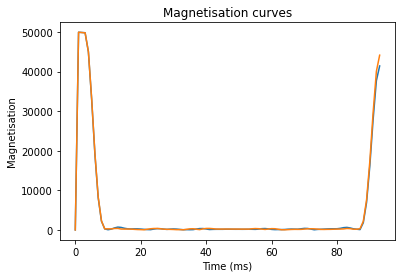

In [11]:
plt.title("Magnetisation curves")
plt.ylabel("Magnetisation")
plt.xlabel("Time (ms)")
plt.plot(trans)
plt.plot(trans0)

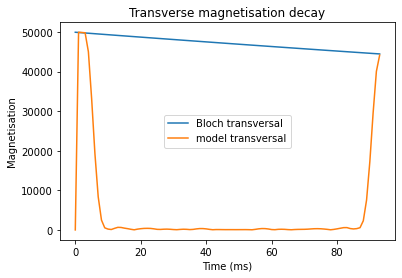

In [15]:
bloch = []
for t in range(steps):
    bloch.append((trans0[1] * (math.exp(-t/(T2)))))
plt.plot(bloch, label="Bloch transversal")
plt.plot(trans0, label="model transversal")
plt.title("Transverse magnetisation decay")
plt.ylabel("Magnetisation")
plt.xlabel("Time (ms)")
plt.legend()

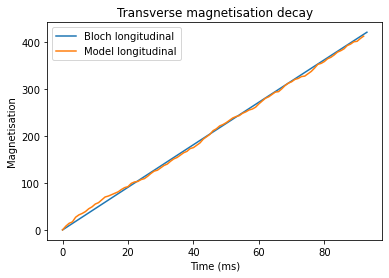

In [14]:
bloch = []
for t in range(steps):
    bloch.append(long[0] * (1-math.exp(-t/(T1))))
    
plt.plot(bloch, label="Bloch longitudinal")
plt.plot(long[1:], label="Model longitudinal")
plt.title("Transverse magnetisation decay")
plt.ylabel("Magnetisation")
plt.xlabel("Time (ms)")
plt.legend()